In [58]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import pickle

from abc import ABC, abstractmethod

import os

from skopt import Optimizer
from skopt.space import Real, Categorical

import scipy.stats as st

from rich.table import Table
from rich.console import Console

from joblib import Parallel, delayed

from scipy.special import softmax

from collections import namedtuple, deque

import copy

import torch

Nota: Al fine di non rendere troppo lunghe le run, gli iperparametri e le politiche addestrate vengono salvate nella directory best

In [59]:
if (not os.path.exists("./Best")) :
    os.makedirs("./Best")

# Traccia A3
L’obiettivo del progetto è implementare e valutare una o più soluzioni basate su reinforcement learning per il problema Mountain Car della suite OpenAI Gymnasium: https://gym.farama.org/environments/classic_control/mountain_car/

## Descrizione
Il MountainCar-v0 è un ambiente deterministico in cui una macchina deve raggiungere la cima di una collina vincendo la gravità. La macchina è inizialmente posizionata in una valle e l'agente deve usare l'accelerazione in modo strategico per raggiungere l'obbiettivo.

### Spazio di Stato
- **Shape:** `(2,)`
- **Elements:**
  - Posizione: `[-1.2, 0.6]` (m)
  - Velocità: `[-0.07, 0.07]` (m/s)

### Spazio delle Azioni
**Discrete(3)**
1. Accelerare sx
2. Non Accelerare
3. Accelerare dx

### Dinamica
Aggiornamento basato su forza, velocità e gravità. Ai confini ci sono degli urti anelstici.

### Reward
Costante: reward di $-1$ per ogni step fino al raggiungimento dell'obbiettivo.

### Stato Iniziale
- Posizione: Uniform random in `[-0.6, -0.4]`
- Velocità: `0`

### Fine Episodio
1. **Terminazione:** Posizione ≥ 0.5 (goal reached)
2. **Troncamento:** 200 timesteps


In [60]:
PROBLEM_NAME = 'MountainCar-v0'

SPACE_RANGE = [-1.2, 0.6]
VEL_RANGE = [-0.07, 0.07]
ACTION_SPACE = 3

# Aspetti Generali

Di seguito vengono definite le tre classi a partire dal quale viene generalizzato il problema:
* La classe *QFunction* definisce un'implementazione della Action Value Function. L'uso di questa classe permette di costruire delle Policy che siano indipendenti dalla particolare implementazione della funzione
* La classe *Policy* definisce un'implementazione di una Politica. Le azioni che la politica restituisce potranno essere sia casuali (esplorazione) sia dettate dai volori attuali della *QFunction* data (sfruttamento della conoscenza acquisita).
* La classe *Agent* definisce un agente che interagisce con l'ambiente seguendo le azioni dettate dalla politica che segue.

I seed passati ai vari metodi sono usati per l'inizializzazione dell'ambiente e dei generatori di numeri casuali al fine di avere la riproducibilità tra run diverse.

In [61]:
class QFunction(ABC) :

    @abstractmethod
    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, targetValue) :
        pass

    @abstractmethod
    def getValue(self, state, action) -> float :
        pass

    @abstractmethod
    def getValues(self, state) -> np.ndarray :
        pass

In [62]:
class Policy(ABC) :
    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction) :
        self.alpha = alpha
        self.gamma = gamma
        self.explorePerc = explorePerc

        self.function = function

    
    @abstractmethod
    def chooseAction(self, state, training) -> int :
        pass

    @abstractmethod
    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        pass

    @abstractmethod
    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        pass


In [63]:
class Agent :

    def __init__(self, policy : Policy) :
        self.policy = policy

    def oneEpisode(self, env : gym.Env, training : bool) -> list:
        currentState = env.reset()[0]
        done = False
        totalReward = 0
        while (not done) :
            action = self.policy.chooseAction(currentState, training)
            nextState, reward, terminated, truncated, _ = env.step(action)

            done = terminated or truncated
            if training :
                self.policy.updatePolicy(currentState, action, reward, nextState, terminated)

            currentState = nextState
            totalReward += reward
            
        return totalReward


    def train(self, episodeNum : int, seed : int) -> np.ndarray :
        env : gym.Env = gym.make(PROBLEM_NAME)

        env.reset(seed = seed)
        env.action_space.seed(seed = seed)

        rewardArray = np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward = self.oneEpisode(env = env, training = True)

            rewardArray[episodeIdx] = episodeReward

            self.policy.updateParams(episodeNum, episodeIdx)

        env.close()

        return rewardArray
    

    def test(self, episodeNum : int, seed : int, display : bool) -> np.ndarray :
        env : gym.Env = gym.make(PROBLEM_NAME, render_mode = "human" if display else None)
        
        env.reset(seed = seed)
        env.action_space.seed(seed = seed)

        rewardArray = np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward  = self.oneEpisode(env, False)
            rewardArray[episodeIdx] = episodeReward

        env.close()

        return rewardArray


In [64]:
TRAIN_SEED = 0
TUNE_SEED = 1
TEST_SEED = 2

TUNER_RANDOM_STATE = 3
TORCH_RANDOM_STATE = 4

In [65]:
TRAIN_EPISODES = 5_000
TUNE_EPISODES = 100
TEST_EPISODES = 100

## Policy

Di seguito vengono proposte due implementazioni di Policy, una basata su Q-Learning e l'altra basata su Sarsa.

Nelle implementazioni proposte è stato adottato:
* Un approccio $\epsilon$-greedy con decadimento lineare dell'$\epsilon$.
* Un approccio Softmax Action Selection con decadimento lineare del $\tau$.

Il tasso di decadimento in entrambi i casi è determinato in funzione di un parametro che rappresenta la percentuale di episodi di addestramento in cui si vuole che si raggiunga il valore minimo dell'$\epsilon$ o del $\tau$. 

In entrambi i casi vengono inizializzati dei generatori di numeri randomici per l'esplorazione e la scelta della prossima azione casuale.

Come riportato in https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/, quando si raggiunge lo stato terminale, il valore $Q(s_{t+1}, *)$ non può essere definito, in quanto l'interazione agente-ambiente è terminata e non esiste in realtà uno stato successivo. Il valore del parametro *terminated* viene quindi usato proprio per discriminare queste situazioni e porre il valore del target come uguale al reward.

Il valore del target così calcolato viene passato come parametro alla function insieme anche alle informazioni $(s_t, a_t, r_t, s_{t+1})$ in modo da avere maggior flessibilità nell'aggiornamento della funzione (e.g. la soluzione con approssimazione basata su DQN non vuole il valore del taget, ma vuole le altre informazioni).

Per la scelta delle azioni è stato implementato un doppio approccio:
* Approccio di esplorazione/sfruttamento in caso di addestramento
* Approccio di puro sfruttamento in caso di test. In caso di test la qFunction associata non viene aggiornata.

### Q-Learning
In questo algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma \cdot max_{a} Q(S_{t+1},a) - Q(S_t,A_t)]$

In [66]:
class Q(Policy) :

    def __init__(self, alpha: float, gamma: float, explorePerc: float, function: QFunction):
        super().__init__(alpha, gamma, explorePerc, function)
    
    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            target += self.gamma * np.max(self.function.getValues(nextState))
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)

#### Epsilon-Greedy

In [67]:
class EpsilonQ(Q) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)


    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        
        if (self.exploreRng.random() < self.epsilon) :
            return self.actionChooseRng.choice(ACTION_SPACE)
        else :
            return np.argmax(self.function.getValues(state))


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.001)
        else :
            self.epsilon = 0.001
        

#### Softmax Action Selection

In [68]:
class TauQ(Q) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, tau : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.baseTau = tau
        self.tau = tau

        self.actionChooseRng = np.random.default_rng(seed)


    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        distribution = softmax(self.function.getValues(state) / self.tau)
        return self.actionChooseRng.choice(ACTION_SPACE, p = distribution)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.tau = self.baseTau - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseTau - 0.0001)
        else :
            self.tau = 0.0001
        

### Sarsa-Learning
In questo algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)]$

In questo caso abbiamo bisogno dell'azione $A_{t+1}$ per aggiornare la funzione. Per fare questo viene definito il metodo *getActionForUpdate* in modo da non riusare i generatori di numeri casuali usati nella scelta della prossima azione.

In [69]:
class Sarsa(Policy) :
    
    def __init__(self, alpha: float, gamma: float, explorePerc: float, function: QFunction):
        super().__init__(alpha, gamma, explorePerc, function)

    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            nextAction = self.getActionForUpdate(nextState)
            target += self.gamma * self.function.getValue(nextState, nextAction)
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)

    @abstractmethod
    def getActionForUpdate(self, nextState) :
        pass
    

#### Epsilon-Greedy
In questo caso il metodo *getActionForUpdate* usa due generatori di numeri casuali diversi da quelli usati nel metodo *chooseAction*. I generatori sono sincronizzati con quelli principali attraverso un set dello stato e, in questo modo, il risultato da loro prodotto sarà lo stesso di quello che verrà prodotto dai generatori principali all'iterazione successiva.

In [70]:
class EpsilonSarsa(Sarsa) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)

        self.otherExploreRng = np.random.default_rng(seed)
        self.otherActionChooseRng = np.random.default_rng(seed)

    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        
        if (self.exploreRng.random() < self.epsilon) :
            return self.actionChooseRng.choice(ACTION_SPACE)
        else :
            return np.argmax(self.function.getValues(state))
        

    def getActionForUpdate(self, nextState) -> int :
        ## Sync generator state --> Generated action will be the same as the next in case of random generation
        self.otherExploreRng.bit_generator.state = self.exploreRng.bit_generator.state
        self.otherActionChooseRng.bit_generator.state = self.actionChooseRng.bit_generator.state 

        if (self.otherExploreRng.random() < self.epsilon) :
            return self.otherActionChooseRng.choice(ACTION_SPACE)
        else :
            return np.argmax(self.function.getValues(nextState))


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.001)
        else :
            self.epsilon = 0.001

#### Softmax Action Selection
Il metodo *getActionForUpdate* è implementato seguendo lo stesso approccio seguito nel caso dell'*$\epsilon$-greedy*

In [71]:
class TauSarsa(Sarsa) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, tau : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.baseTau = tau
        self.tau = tau

        self.actionChooseRng = np.random.default_rng(seed)
        self.otherActionChooseRng = np.random.default_rng(seed)

    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        distribution = softmax(self.function.getValues(state) / self.tau)
        return self.actionChooseRng.choice(ACTION_SPACE, p = distribution)
    
    def getActionForUpdate(self, nextState):
        self.otherActionChooseRng.bit_generator.state = self.actionChooseRng.bit_generator.state

        distribution = softmax(self.function.getValues(nextState) / self.tau)
        return self.otherActionChooseRng.choice(ACTION_SPACE, p = distribution)

    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.tau = self.baseTau - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseTau - 0.0001)
        else :
            self.tau = 0.0001

## Tuning
Definiamo di seguito una classe generica per il tuning degli iperparametri.

La sintonizzazione è stata effettuata con l'uso della libreria *scikit-optimize* che permette una valutazione in parallelo dei punti: la classe Optimizer esegue un'ottimizzazione bayesiana dei punti cercando il punto ottimo nello spazio degli iperparametri specificati.

Il tuning è stato eseguito:
1. Addestrando gli agenti partendo sempre dallo stesso seed
2. Valutando gli agenti addestrati su un ambiente inizializzato con un seed diverso
3. Prendendo come parametro di riferimento il reward medio ottenuto in valutazione

In [72]:
class Tuner(ABC) :

    def __init__() :
        pass

    @abstractmethod
    def objective(self, params) :
        pass

    def tune(self, calls, randomState, space, jobsNum) :
        optimizer = Optimizer(
            dimensions = space, 
            random_state = randomState,
        )

        for i in range(calls // jobsNum):
            print(f"Step >>> {i}")
            x = optimizer.ask(n_points=jobsNum)  # x is a list of n_points points
                
            y = Parallel(
                n_jobs = jobsNum
            )(delayed(self.objective)(params) for params in x)  # evaluate points in parallel
            optimizer.tell(x, y)

            bestIdx = np.argmin(optimizer.yi)
            print(f"Best Value So Far >>> {optimizer.yi[bestIdx]}")
            print(f"Best Params So Far >>> {optimizer.Xi[bestIdx]}")
            print()
        
        bestIdx = np.argmin(optimizer.yi)
        print(f"Best Value >>> {optimizer.yi[bestIdx]}")
        print(f"Best Params >>> {optimizer.Xi[bestIdx]}")
        print()
        print()

        return optimizer.Xi[bestIdx]

## Utils

In [73]:
def loadDictFromFile(fileName : str) -> dict :
    if (os.path.exists(fileName)) :
        with open(fileName, 'rb') as f:
            return pickle.load(f)
    else :
        return {}

In [74]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table:
    table = Table(title = testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

In [75]:
def drawParamsTable(paramsDict : dict, ) :
    table = buildTable("Best Params", ["LearnerName", "Alpha", "Gamma", "ExploreParam", "ExplorePerc"], [False, False, True, True, True])
    for key in paramsDict :
        table.add_row(
            key, 
            str(paramsDict[key][0]), 
            str(paramsDict[key][1]), 
            str(paramsDict[key][2]), 
            str(paramsDict[key][3])
        )

    Console().print(table)

In [76]:
def plotTrainTrend(rewardArray : np.ndarray, episodeNum : int, learnerName : str) :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

    axes[0].plot(np.array(rewardArray))
    axes[0].set_xlabel("Episode Idx")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Reward During Training")
    axes[0].grid(True)
    
    mean_rewards = np.zeros(episodeNum)
    for t in range(episodeNum):
            mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
    axes[1].plot(mean_rewards)
    axes[1].set_xlabel("Episode Idx")
    axes[1].set_ylabel("Avg Reward - 100 Episodes")
    axes[1].set_title("Avg Reward Trend During Training")
    axes[1].grid(True)

    fig.suptitle(f"{learnerName} - Training")
    plt.tight_layout()
    plt.show()
    plt.clf()

In [77]:
## Non avendo molto senso l'interpolazione, ma trovando troppo confusionario lo scatter plot, la connessione tra i punti è stata
## rappresentata usando una linea con tratteggio.

def plotTestTrend(policyList : list[Policy], testEpisodes : int, testSeed : int) :

    plt.figure(figsize = (15,5))

    for policy in policyList :
        agent = Agent(policy)
        rewardArray = agent.test(testEpisodes, testSeed, False)
        plt.plot(rewardArray, label = policy.__class__.__name__, marker = "o", linestyle = "--")

        cumAvg = np.cumsum(rewardArray) / np.arange(1, len(rewardArray) + 1)
        plt.plot(cumAvg, label = policy.__class__.__name__ + " - Cum Reward Avg")

    plt.legend()
    plt.grid(True, axis = "y")
    plt.ylabel("Reward")
    plt.xlabel("Attempt Index")
    plt.title(f"Testing Trend")
    plt.tight_layout()
    plt.show()
    plt.clf()

In [78]:
def drawTestTable(policyList : list[Policy], testEpisodes : int, testSeed : int) :
    table = buildTable(f"Testing Reward Info", ["LearnerName", "Avg Reward", "Reward Std Dev", "Confidence Interval 95%"], [False, True, True, True])
    for policy in policyList :
        agent = Agent(policy)
        rewardArray = agent.test(testEpisodes, testSeed, False)
        confidenceInterval = st.t.interval(
            confidence = 0.95,
            df = len(rewardArray) - 1,
            loc=np.mean(rewardArray), 
            scale=st.sem(rewardArray)
        )
        confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
        table.add_row(policy.__class__.__name__, str(rewardArray.mean()), str(rewardArray.std()), confidenceString)
    
    Console().print(table)

# Soluzione con ricerca tabulare
Per definire delle soluzioni basate su ricerca tabulare, abbiamo bisogno prima di tutto di una matrice che ci tenga traccia dei valori della funzione $Q(s,a)$. In questo caso specifico lo stato del problema non è discreto, bensì continuo, in quanto formato da i valori della posizione e della velocità i quali a loro volta variano in un insieme continuo.

Al fine di definire delle soluzioni basate su ricerca tabulare quindi definiamo una discretizzazione dello stato che ci permetta di definire la funzione $Q(s,a)$; notiamo invece che per quanto riguarda l'insieme $A$ delle azioni esso è già discreto e non ci dà problemi in termini di definizione della funzione.

Una soluzione basata su questo tipo di soluzioni comporta un consumo di memoria dato da $|S| \cdot |A|$, dove $|A|$ nel nosto caso è pari a $3$, mentre $|S|$ dipende dalla discretizzazione che facciamo dello stato: supposto di dividere l'inervallo della posizione in $5$ slot e quello delle velocità in altrettanti, avremo un numero totale di stati pari a $25$.

In questo caso, come si vede dall'implementazione, il valore dell'incremento della funzione viene calcolato partendo dal target e applicando la relazione:   

$Q(S,A) \leftarrow Q(S,A) + \alpha [target - Q(S,A)]$

Dove il calcolo del target cambia a seconda che si tratti di Q-Learning o Sarsa.

In [79]:
class BucketQFunction(QFunction) :

    def __init__(self, spaceRange : list, spaceBins : int, velRange : list, velBins : int, actionSpace : int) :
        self.q : np.ndarray = np.zeros([spaceBins, velBins, actionSpace])

        self.spaceLinSpace = np.linspace(
            spaceRange[0], 
            spaceRange[1], 
            spaceBins + 1
        )

        self.velLinSpace = np.linspace(
            velRange[0], 
            velRange[1], 
            velBins + 1
        )

    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, targetValue):
        spaceSlot, velSlot = self._computeSlots(currentState)
        increment = alpha * (targetValue - self.getValue(currentState, action))

        self.q[spaceSlot, velSlot, action] += increment
    
    def getValue(self, state, action):
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, action]
    
    def getValues(self, state) :
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, :]
    
    def _computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return spaceSlot, velocitySlot

## Tuning

Di seguito si procede alla sintonizzazione degli iperparametri.
Come iperparametri da sintonizzare sono stati considerati i seguenti:
* $\alpha$, learning rate
* $\gamma$, fattore di sconto
* $explorePerc$, percentuale di episodi di decadimento del parametro di esplorazione

Altri iperparametri che non sono stati calibrati, ma sono stati scelti ad occhio per non rallentare eccessivamente l'esecuzione sono stati:
* Numero di Episodi di Addestramento: impostato a $5000$
* Numero di bucket: impostato a $20$. Il valore permette una buona discretizzazione sia dello spazio sia della velocità. Nello specifico:
    * Lo spazio è diviso in intervalli di lunghezza $0.09$ metri, cioè $9$ cm
    * La velocità è divisa in intervalli di lunghezza $0.007$ m/s
* $\epsilon$ (oppure $\tau$), parametri di esplorazione; in entrambi i casi vengono impostati a dei valori abbastanza alti per favorire l'esplorazione nei primi episodi

In [80]:
class BucketTuner(Tuner) :

    def __init__(self, PolicyClass, trainEpisodes : int, tuneEpisodes : int, trainSeed : int, tuneSeed : int) :
        self.PolicyClass = PolicyClass
        self.trainEpisodes = trainEpisodes
        self.tuneEpisodes = tuneEpisodes
        self.trainSeed = trainSeed
        self.tuneSeed = tuneSeed

    def objective(self, params):
        alpha, gamma, exploreParam, explorePerc = params

        function = BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        policy = self.PolicyClass(alpha, gamma, explorePerc, function, self.trainSeed, exploreParam)
        agent = Agent(policy)
        trainRewardArray = agent.train(self.trainEpisodes, self.trainSeed)
        tuneRewardArray= agent.test(self.tuneEpisodes, self.tuneSeed, False)
        
        meanTune = -tuneRewardArray.mean()
        objValue = meanTune
        return objValue

### Spazi di Ricerca e Funzione di Tuning

In [81]:
epsilonSpace = [
    Real(0.01, 0.4, name = 'alpha'),
    Real(0.8, 1.0, name = 'gamma'),
    Categorical([1.0], name = "epsilon"),
    Real(0.1, 0.7, name = "explorePerc"),
]

tauSpace = [
    Real(0.01, 0.4, name = 'alpha'),
    Real(0.8, 1.0, name = 'gamma'),
    Categorical([5.0], name = "tau"),
    Real(0.1, 0.7, name = "explorePerc"),
]

In [82]:
def tuneBucketLearner(Policy, trainEpisodes, bestDict, space, fileName : str) -> list :
    key = Policy.__name__
    print(f"Looking For {key} Best Params")
    if (not key in bestDict) :
        bestParams = BucketTuner(Policy, trainEpisodes, TUNE_EPISODES, TRAIN_SEED, TUNE_SEED).tune(150, TUNER_RANDOM_STATE, space, 5)
        bestDict[key] = bestParams
        with open(fileName, 'wb') as f:
            pickle.dump(bestDict, f)
    else :
        bestParams = bestDict[key]

    return bestParams

## Epsilon-Greedy

### Tuning

In [83]:
EPSILON_PARAMS_FILE_NAME = './Best/EpsilonParams.pkl'

epsilonParamsDict = loadDictFromFile(EPSILON_PARAMS_FILE_NAME)

tuneBucketLearner(EpsilonQ, TRAIN_EPISODES, epsilonParamsDict, epsilonSpace, EPSILON_PARAMS_FILE_NAME)
tuneBucketLearner(EpsilonSarsa, TRAIN_EPISODES, epsilonParamsDict, epsilonSpace, EPSILON_PARAMS_FILE_NAME)

Looking For EpsilonQ Best Params
Looking For EpsilonSarsa Best Params


[0.3250367208663042, 0.9376467424010039, 1.0, 0.12596817270046584]

In [84]:
drawParamsTable(epsilonParamsDict)

                                          Best Params                                           
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ Alpha               ┃ Gamma              ┃ ExploreParam ┃ ExplorePerc         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ EpsilonQ     │ 0.20982142896945968 │ 1.0                │ 1.0          │ 0.1                 │
│ EpsilonSarsa │ 0.3250367208663042  │ 0.9376467424010039 │ 1.0          │ 0.12596817270046584 │
└──────────────┴─────────────────────┴────────────────────┴──────────────┴─────────────────────┘

### Addestramento
Trovati i parametri migliori procediamo all'addestramento degli agenti con questi parametri e a tracciare le curve di addestramento.

In [85]:
EPSILON_TRAINED_FILE_NAME = "./Best/EpsilonTrained.pkl"

def trainAgent(PolicyClass, fileName, trainDict, bestParamsDict, episodeNum) -> tuple[Policy, np.ndarray] :
    key = PolicyClass.__name__
    if (not key in trainDict) :
        alpha, gamma, exploreParam, explorePerc = bestParamsDict[key]
        function = BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        policy = PolicyClass(alpha, gamma, explorePerc, function, TRAIN_SEED, exploreParam)
        agent = Agent(policy)

        rewardArray = agent.train(episodeNum, TRAIN_SEED)
        
        trainDict[key] = [policy, rewardArray]
        with open(fileName, 'wb') as f:
            pickle.dump(trainDict, f)
    else :
        policy : Policy = trainDict[key][0]
        rewardArray = trainDict[key][1]
    
    plotTrainTrend(rewardArray, episodeNum, key)

    return policy, rewardArray

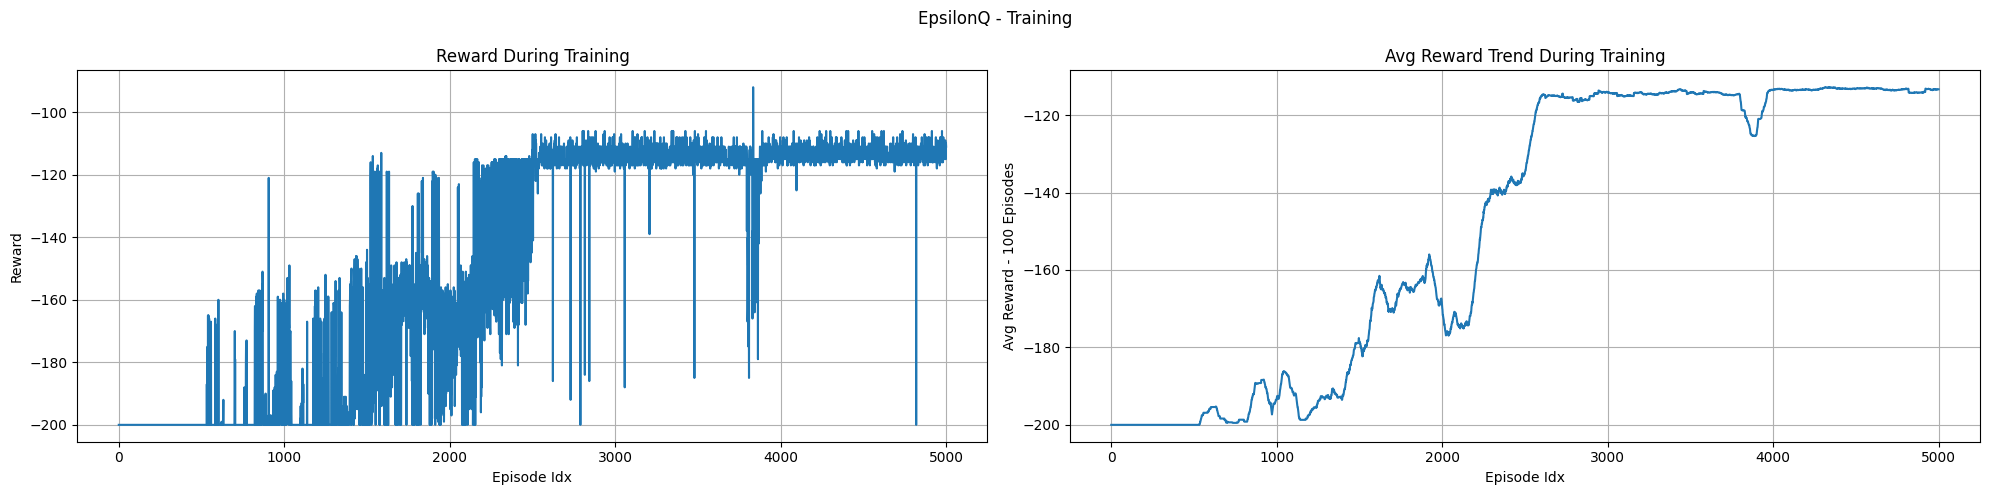

<Figure size 640x480 with 0 Axes>

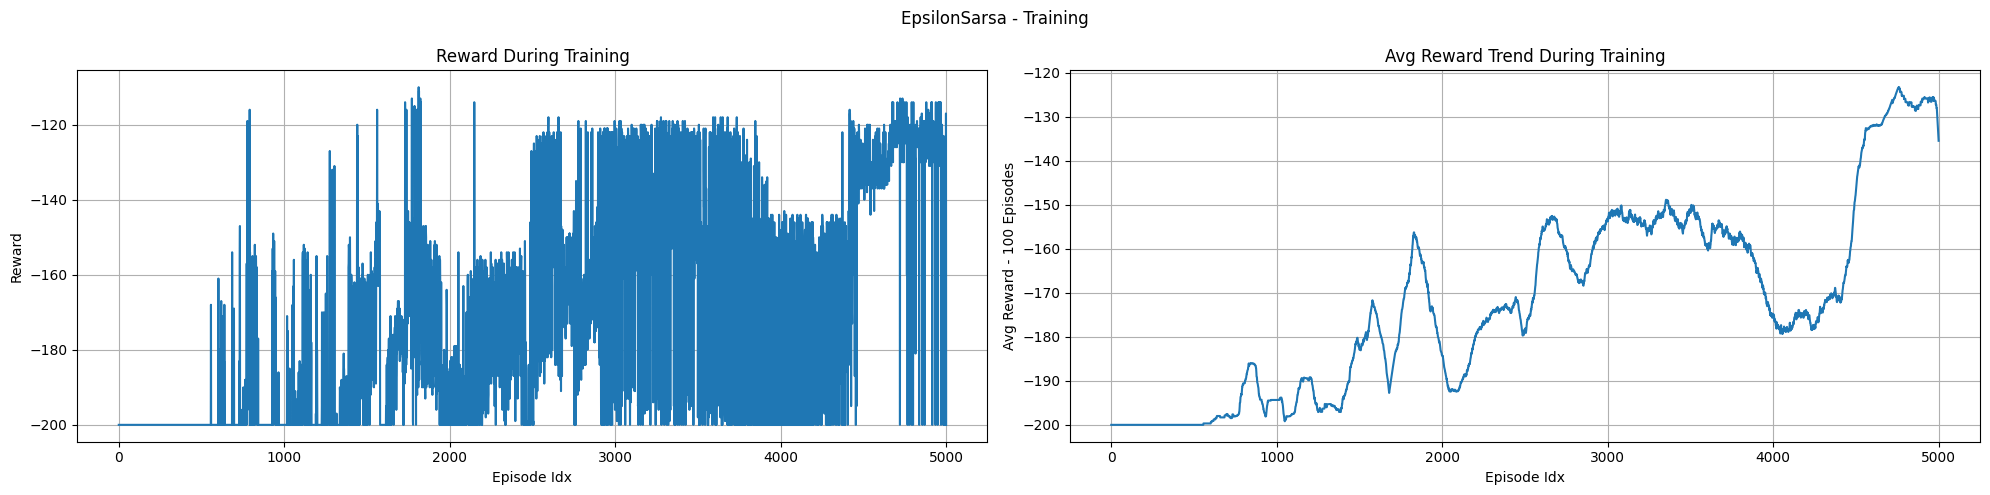

<Figure size 640x480 with 0 Axes>

In [86]:
epsilonTrainedDict = loadDictFromFile(EPSILON_TRAINED_FILE_NAME)

epsilonQ, _ = trainAgent(EpsilonQ, EPSILON_TRAINED_FILE_NAME, epsilonTrainedDict, epsilonParamsDict, TRAIN_EPISODES)
epsilonSarsa, _ = trainAgent(EpsilonSarsa, EPSILON_TRAINED_FILE_NAME, epsilonTrainedDict, epsilonParamsDict, TRAIN_EPISODES)

### Testing

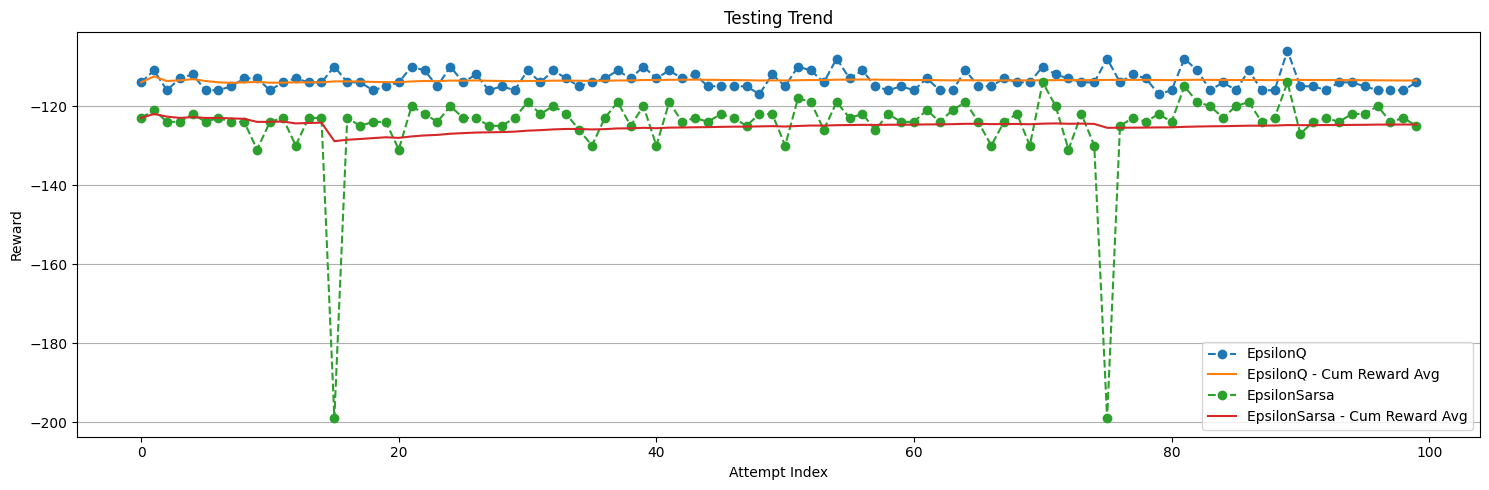

<Figure size 640x480 with 0 Axes>

In [87]:
plotTestTrend([epsilonQ, epsilonSarsa], TEST_EPISODES, TEST_SEED)

In [88]:
drawTestTable([epsilonQ, epsilonSarsa], TEST_EPISODES, TEST_SEED)

                                     Testing Reward Info                                      
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ EpsilonQ     │ -113.54    │ 2.233472632471685  │ -113.98540203150387 / -113.09459796849615 │
│ EpsilonSarsa │ -124.67    │ 11.125695483878747 │ -126.88870073461744 / -122.45129926538256 │
└──────────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

Osservando i risultati grafici e tabulari, si vede come la soluzione migliore è quella con Q-Learning, con uno scarto di circa 10 step. Inoltre vi sono alcuni casi, anche se rari, in cui il Sarsa non riesce ad arrivare ad una soluzione del problema.

## Softmax Action-Selection

### Tuning

In [89]:
TAU_PARAMS_FILE_NAME = "./Best/TauParams.pkl"
tauParamsDict = loadDictFromFile(TAU_PARAMS_FILE_NAME)

tuneBucketLearner(TauQ, TRAIN_EPISODES, tauParamsDict, tauSpace, TAU_PARAMS_FILE_NAME)
tuneBucketLearner(TauSarsa, TRAIN_EPISODES, tauParamsDict, tauSpace, TAU_PARAMS_FILE_NAME)

Looking For TauQ Best Params
Looking For TauSarsa Best Params


[0.1648168993445489, 1.0, 5.0, 0.1]

In [90]:
drawParamsTable(tauParamsDict)

                               Best Params                                
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ LearnerName ┃ Alpha               ┃ Gamma ┃ ExploreParam ┃ ExplorePerc ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ TauQ        │ 0.23953311558438622 │ 1.0   │ 5.0          │ 0.1         │
│ TauSarsa    │ 0.1648168993445489  │ 1.0   │ 5.0          │ 0.1         │
└─────────────┴─────────────────────┴───────┴──────────────┴─────────────┘

### Addestramento

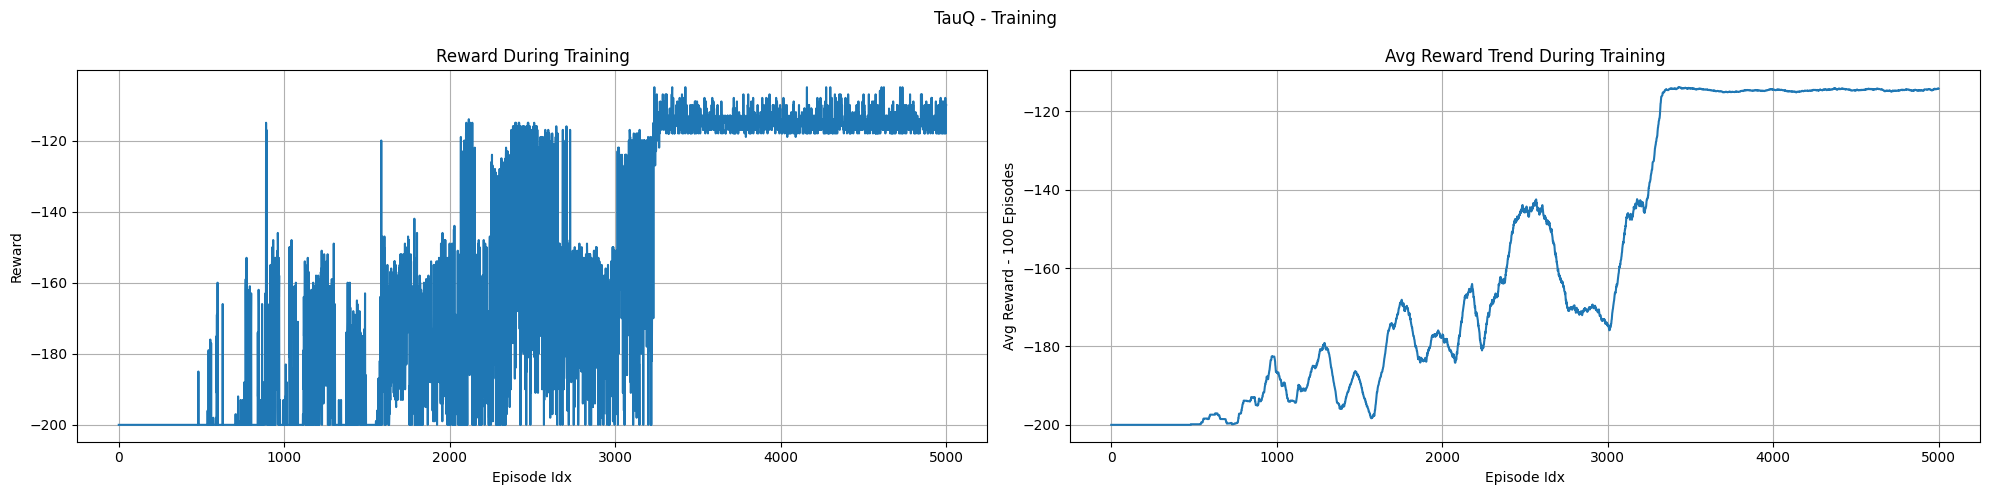

<Figure size 640x480 with 0 Axes>

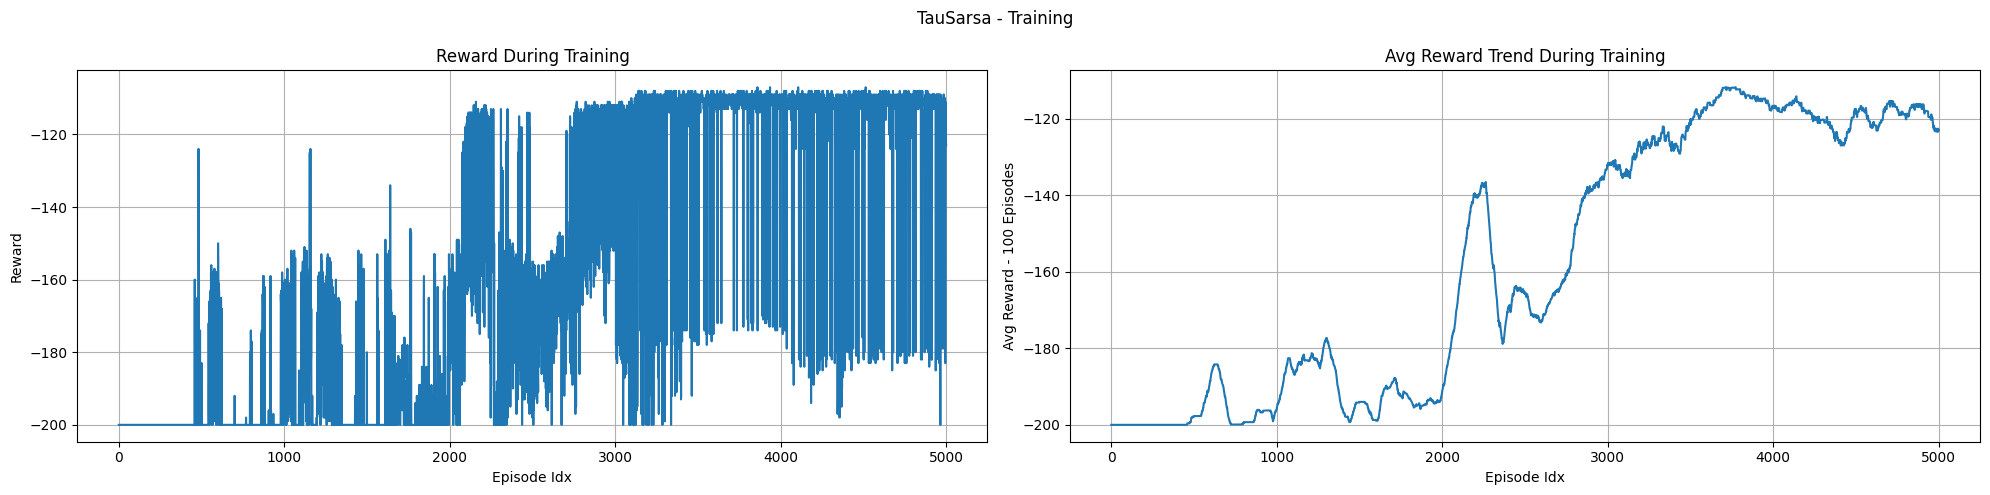

<Figure size 640x480 with 0 Axes>

In [91]:
TAU_TRAINED_FILE_NAME = "./Best/TauTrained.pkl"

tauTrainedDict = loadDictFromFile(TAU_TRAINED_FILE_NAME)

tauQ, _ = trainAgent(TauQ, TAU_TRAINED_FILE_NAME, tauTrainedDict, tauParamsDict, TRAIN_EPISODES)
tauSarsa, _ = trainAgent(TauSarsa, TAU_TRAINED_FILE_NAME, tauTrainedDict, tauParamsDict, TRAIN_EPISODES)

### Testing

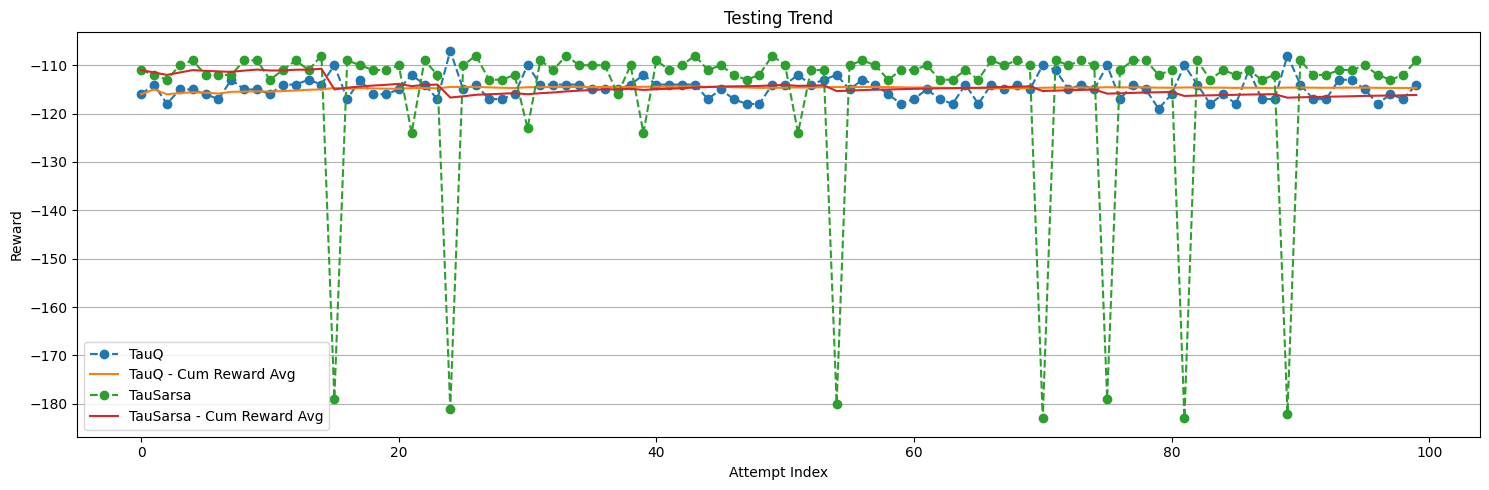

<Figure size 640x480 with 0 Axes>

In [92]:
plotTestTrend([tauQ, tauSarsa], TEST_EPISODES, TEST_SEED)

In [93]:
drawTestTable([tauQ, tauSarsa], TEST_EPISODES, TEST_SEED)

                                     Testing Reward Info                                     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ TauQ        │ -114.7     │ 2.2781571499789037 │ -115.15431307638757 / -114.24568692361244 │
│ TauSarsa    │ -116.15    │ 18.039054853289848 │ -119.7473718957878 / -112.55262810421222  │
└─────────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

Nel caso della Softmax Action Selection, sembra essere il Sarsa ad avere le prestazioni medie migliori, sebbene caratterizzato da una varianza maggiore dovuta ai picchi negativi che possiamo vedere nella rappresentazione grafica.

## Double-Learning
Vediamo come si comporta una soluzione basata su Double Learning e se effettivamente apporta beneficio rispetto alla versione base. Abbiamo qui considerato soltanto una versione del DoubleLearning per il QLearning e per la politica di selezione $\epsilon$-greedy.

![Logo di Python](https://miro.medium.com/v2/resize:fit:640/format:webp/1*NvvRn59pz-D1iSkBWpuIxA.png)

L'uso del Double-QLearning permette di ridurre il bias di massimizzazione (dovuto al fatto che viene presa l'azione che massimizza il valore della Q nel calcolo del target): usando due funzioni Q separate e usando una nel calcolo del target e una come funzione che viene aggiornata, riusciamo a ridurre questo bias. Si tratta di un approccio molto simile a quello che si adotta introducendo la target network negli algoritmi deep.


In [94]:
class DoubleQ(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.q_1 : QFunction = copy.deepcopy(function)
        self.q_2 : QFunction = copy.deepcopy(function)

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)

        self.functionChooser = np.random.default_rng(seed)

    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.q_1.getValues(state) + self.q_2.getValues(state))
        
        if (self.exploreRng.random() < self.epsilon) :
            return self.actionChooseRng.choice(ACTION_SPACE)
        else :
            return np.argmax(self.q_1.getValues(state) + self.q_2.getValues(state))


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        toUpdate = None
        other = None
        if (self.functionChooser.random() < 0.5) :
            toUpdate = self.q_1
            other = self.q_2
        else :
            toUpdate = self.q_2
            other = self.q_1

        target = reward
        if (not terminated) :
            nextAction = np.argmax(toUpdate.getValues(nextState))
            target += self.gamma * other.getValue(nextState, nextAction)
        toUpdate.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.001)
        else :
            self.epsilon = 0.001

### Tuning

In [95]:
DOUBLE_PARAMS_FILE_NAME = "./Best/DoubleParams.pkl"
doubleParamsDict = loadDictFromFile(DOUBLE_PARAMS_FILE_NAME)

tuneBucketLearner(DoubleQ, TRAIN_EPISODES, doubleParamsDict, epsilonSpace, DOUBLE_PARAMS_FILE_NAME)

Looking For DoubleQ Best Params


[0.20671735247875775, 1.0, 1.0, 0.1]

In [96]:
drawParamsTable(doubleParamsDict)

                               Best Params                                
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ LearnerName ┃ Alpha               ┃ Gamma ┃ ExploreParam ┃ ExplorePerc ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DoubleQ     │ 0.20671735247875775 │ 1.0   │ 1.0          │ 0.1         │
└─────────────┴─────────────────────┴───────┴──────────────┴─────────────┘

### Addestramento

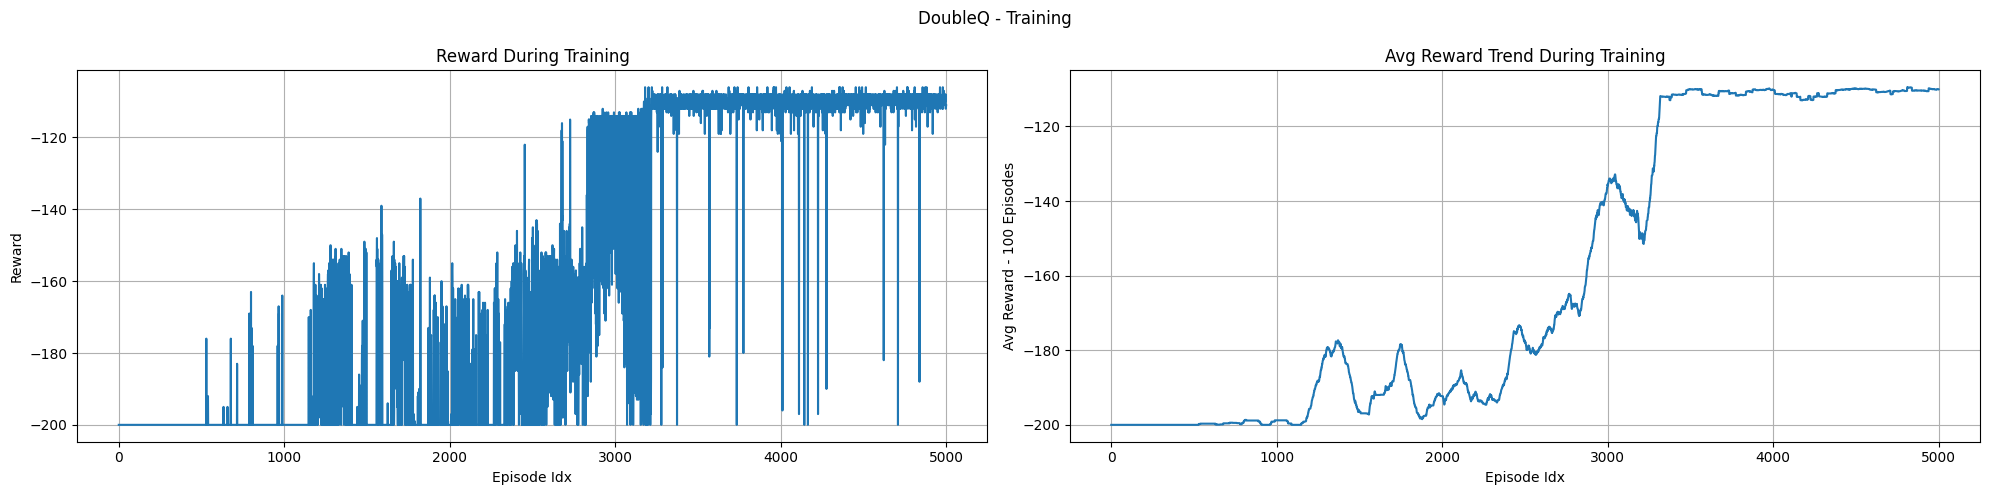

<Figure size 640x480 with 0 Axes>

In [97]:
DOUBLE_TRAINED_FILE_NAME = "./Best/DoubleTrained.pkl"
doubleTrainedDict = loadDictFromFile(DOUBLE_TRAINED_FILE_NAME)

doubleQ, _ = trainAgent(DoubleQ, DOUBLE_TRAINED_FILE_NAME, doubleTrainedDict, doubleParamsDict, TRAIN_EPISODES)

### Testing

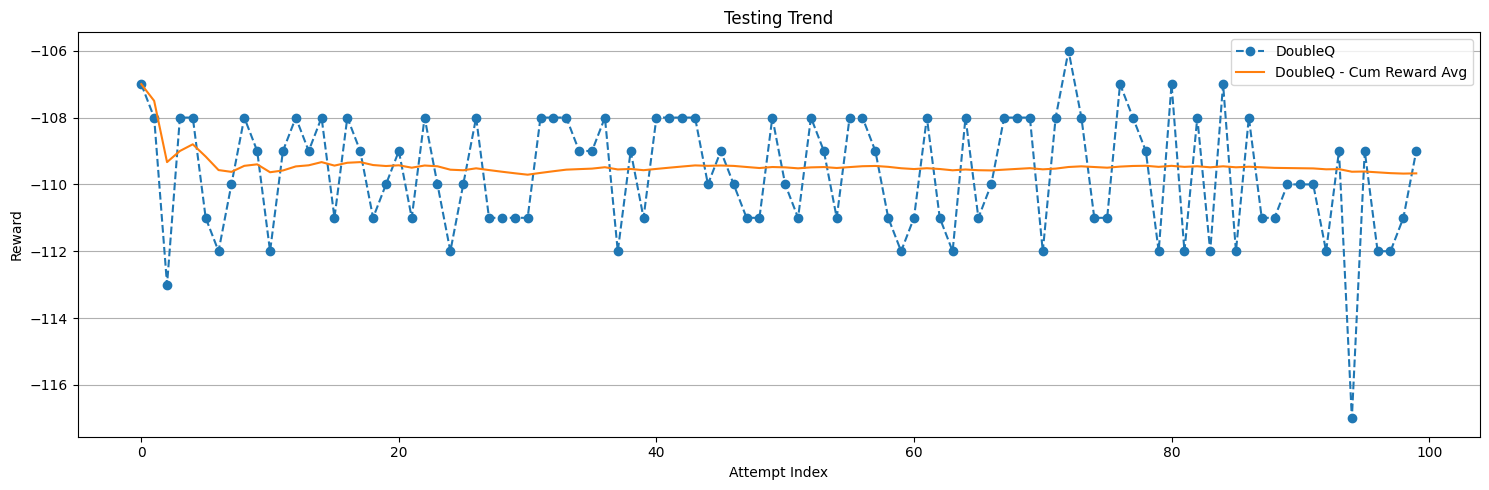

                                    Testing Reward Info                                     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ DoubleQ     │ -109.67    │ 1.7779482557149968 │ -110.02456076492321 / -109.3154392350768 │
└─────────────┴────────────┴────────────────────┴──────────────────────────────────────────┘

<Figure size 640x480 with 0 Axes>

In [98]:
plotTestTrend([doubleQ], TEST_EPISODES, TEST_SEED)
drawTestTable([doubleQ], TEST_EPISODES, TEST_SEED)

## Confronti
Procediamo qui al confronto tra le diverse soluzioni proposte.

Notiamo che:
* Nel caso $\epsilon$-greedy l'algoritmo di QLearning presenta prestazioni migliori rispetto al Sarsa
* Nel caso di Softmax Action Selection, la differenza prestazionale si assottiglia, sebbene sia ancora il QLearning a vincere
* Nel caso del Sarsa, visto l'aumento del reward medio, la Softmax Action Selection sembra dare prestazioni migliori anche se a costo di un aumento della varianza
* L'uso della Double Function nel QLearning permette di migliorare ancora le prestazioni del QLearning

In conclusione l'algoritmo con le prestazioni migliori nel caso tabulare risulta essere proprio il Double QLearning, non solo in termini di reward medio, ma anche, considerata la bassa deviazione standard, in termini di stabilità della soluzione.


In [99]:
drawTestTable([epsilonQ, tauQ, doubleQ, epsilonSarsa, tauSarsa], TEST_EPISODES, TEST_SEED)

                                     Testing Reward Info                                      
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ EpsilonQ     │ -113.54    │ 2.233472632471685  │ -113.98540203150387 / -113.09459796849615 │
│ TauQ         │ -114.7     │ 2.2781571499789037 │ -115.15431307638757 / -114.24568692361244 │
│ DoubleQ      │ -109.67    │ 1.7779482557149968 │ -110.02456076492321 / -109.3154392350768  │
│ EpsilonSarsa │ -124.67    │ 11.125695483878747 │ -126.88870073461744 / -122.45129926538256 │
│ TauSarsa     │ -116.15    │ 18.039054853289848 │ -119.7473718957878 / -112.55262810421222  │
└──────────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

# Soluzione con approssimazione

## Approssimazione con DQN

### Soluzione A Mano con PyTorch

La soluzione con approssimazione è state realizzata usando la libreria Pytorch: l'uso di questa libreria è risultato molto più efficiente da un punto di vista temporale rispetto all'uso di Keras.

In generale è stato notato che l'uso della GPU non porta particolari miglioramenti in termini prestazionali: questo è probabilmente dovuto al fatto che essendo i batch su cui si fanno i passi piccoli ed essendo fatto un singolo passo per volta, l'overhead di spostamento dei dati da memoria principale a memoria globale della GPU prevale sul tempo di esecuzione.

In [100]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [101]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'nextState', 'notTerminated'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.rng = np.random.default_rng(seed = 0)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        indices = self.rng.choice(len(self.memory), size=batch_size)  # Campionamento senza sostituzione
        return [self.memory[i] for i in indices]

    def __len__(self):
        return len(self.memory)

In [102]:
class DQNFunction(QFunction) :

    def __init__(
            self, 
            policyNet : torch.nn.Sequential, 
            targetNet : torch.nn.Sequential, 
            updateTargetPeriod : int = 16, 
            batchSize : int = 128, 
            memoryCapacity : int = 10_000
        ) :
        self.policyNet = policyNet
        self.targetNet = targetNet

        self.updateTargetPeriod = updateTargetPeriod
        self.updateCount = 0
        self.batchSize = batchSize

        self.targetNet.load_state_dict(self.policyNet.state_dict())

        self.replayMemory = ReplayMemory(memoryCapacity)

        self.optimizer = torch.optim.AdamW(self.policyNet.parameters(), lr=1e-4, amsgrad=True)
        

    def getValue(self, state, action) -> float:
        # convertedState = tf.convert_to_tensor([state])
        # return self.policyNet.predict_on_batch(convertedState)[action]
        with torch.no_grad() :
            convertedState = torch.tensor(state)
            result = self.policyNet.forward(convertedState)
            return result.numpy()[action]
    
    def getValues(self, state) -> np.ndarray:
        # convertedState = tf.convert_to_tensor([state])
        # value = self.policyNet.predict_on_batch(convertedState)
        # return value
        with torch.no_grad() :
            convertedState = torch.tensor(state)
            result = self.policyNet.forward(convertedState)
            return result.numpy()
    
    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, target):
        self.replayMemory.push(
            torch.tensor(currentState, device = device).unsqueeze(0), 
            torch.tensor([action], dtype = torch.int64, device = device), 
            torch.tensor([reward], dtype = torch.float32, device = device), 
            torch.tensor(nextState, device = device).unsqueeze(0),
            torch.tensor([not terminated], dtype = torch.bool)
        )

        if (len(self.replayMemory) < self.batchSize) :
            return
        
        batch = self.replayMemory.sample(self.batchSize)
        batch = Transition(*zip(*batch))

        stateBatch = torch.cat(batch.state)
        actionBatch = torch.cat(batch.action).unsqueeze(1)
        rewardBatch = torch.cat(batch.reward)
        nextStateBatch = torch.cat(batch.nextState)
        notTerminalBatch = torch.cat(batch.notTerminated)


        predictedValues : torch.Tensor = self.policyNet.forward(stateBatch).gather(1, actionBatch)

        nextStateValues = torch.zeros(self.batchSize)
        with torch.no_grad():
            nextStateValues[notTerminalBatch] = self.targetNet.forward(nextStateBatch[notTerminalBatch]).max(1).values
            # Compute the expected Q values
        expectedValues : torch.Tensor = rewardBatch + gamma * nextStateValues
        expectedValues = expectedValues.unsqueeze(1)

        self._trainNetworks(predictedValues, expectedValues)
        
    
    def _trainNetworks(self, predictedValues, expectedValues) :

        # loss = torch.nn.functional.mse_loss(predictedValues, expectedValues)
        loss = torch.nn.functional.smooth_l1_loss(predictedValues, expectedValues)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policyNet.parameters(), 100)
        self.optimizer.step()

        self.updateCount += 1
        if (self.updateCount % self.updateTargetPeriod == 0) :
            self.targetNet.load_state_dict(self.policyNet.state_dict())

In [103]:
def buildNetwork(inputUnits : int, outputUnits : int, hiddenUnits : int) :
    return torch.nn.Sequential(
        torch.nn.Linear(inputUnits, hiddenUnits),
        torch.nn.ReLU(),
        torch.nn.Linear(hiddenUnits, hiddenUnits),
        torch.nn.ReLU(),
        torch.nn.Linear(hiddenUnits, outputUnits),
    )

In [104]:
torch.manual_seed(TORCH_RANDOM_STATE)

policyNet = buildNetwork(2, ACTION_SPACE, 128)
targetNet = buildNetwork(2, ACTION_SPACE, 128)

dqnFunction = DQNFunction(policyNet, targetNet, 128, 1024, 100_000)
policy = EpsilonQ(0.21, 0.8, 0.5, dqnFunction, TRAIN_SEED, 0.5)

policy = Agent(policy)
# learnArray = policy.train(TRAIN_EPISODES, TRAIN_SEED)
# plotTrainTrend(learnArray, TRAIN_EPISODES, "QLearner")

Questa implementazione, sebbene corretta, richiede un tempo di esecuzione molto alto e risulta ancora poco efficiente per eseguire l'addestramento su molti episodi.

### Soluzione con Stable-Baseline3
Stable-Baseline3 è una libreria Python che usa PyTorch a basso livello e che fornisce già implementati un numero molto alto di algoritmi di RL che risultano molto efficienti.

In [105]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

Implementiamo di seguito una Policy che prende in input una DQN della libreria SB3. In questo caso l'unico metodo da implementare è la *chooseAction*: infatti gli altri due metodi sono usati in fase di addestramento ma, come vediamo in seguito, l'addestramento della DQN viene fatto esternamente.

Al link https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html si trova la documentazione per la classe DQN: la classe usa internamente target network, replay buffer e gradient clipping per la stabilizzazione dell'apprendimento.

In [106]:
class DQNPolicy(Policy) :

    def __init__(self, dqn : DQN) :
        super().__init__(0, 0, 0, None)
        self.dqn = dqn

    def chooseAction(self, state, training) -> int:
        action, _states = self.dqn.predict(state, deterministic=True)
        return action

    ## Questa funzione viene chiamata solo in fase di training, che viene eseguito fuori sulla DQN passata
    ## Come parametro, quindi non deve fare nulla
    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        pass

    ## Questa funzione viene chiamata solo in fase di training, che viene eseguito fuori sulla DQN passata
    ## Come parametro, quindi non deve fare nulla
    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        pass

#### Tuning
Per il tuning degli iperparametri si è fatto riferimento a quelli trovati dall'estensione *stable-baseline3 zoo*; gli iperparametri migliori individuati dall'estensione sono (https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml):
- 'batch_size', 128
- 'buffer_size', 10000
- 'exploration_final_eps', 0.07
- 'exploration_fraction', 0.2
- 'gamma', 0.98
- 'gradient_steps', 8
- 'learning_rate', 0.004
- 'learning_starts', 1000
- 'n_timesteps', 120000.0
- 'policy', 'MlpPolicy'
- 'policy_kwargs', 'dict(net_arch=[256, 256])'
- 'target_update_interval', 600
- 'train_freq', 16
- 'normalize', False

#### Addestramento

In [107]:
BEST_DQN_MONITOR_FILE_NAME = "./Best/BestDqnMonitor.pkl"
BEST_DQN_TRAINED_FILE_NAME = "./Best/BestDqn.zip"

In [108]:
if (os.path.exists(BEST_DQN_MONITOR_FILE_NAME) and os.path.exists(BEST_DQN_TRAINED_FILE_NAME)) :
    with open(BEST_DQN_MONITOR_FILE_NAME, 'rb') as f:
        monitor = pickle.load(f)
    dqn = DQN.load(BEST_DQN_TRAINED_FILE_NAME)

Viene quindi costruita la DQN sulla base degli iperparametri travati dall'estensione. Il metodo *learn* della DQN prende come parametro il valore *total_timesteps* che rappresenta il numero di step totali che vengono eseguiti sull'ambiente; come valore è stato impostato, per mantenersi coerenti con l'addestramento degli altri metodi, un numero di timestep pari a $200 * TRAIN\_EPISODES$, dove $200$ rappresenta il numero massimo ti timestep per episodio.

Anche in questo modo salviamo la DQN addestrata su un file per non addestrarla una seconda volta. 

L'ambiente di addestramento viene invece racchiuso in una classe *Monitor* che ci permette di monitorare il reward ottenuto dai vari episodi di addestramento.

In [109]:
env = gym.make(PROBLEM_NAME)
env.reset(seed = TRAIN_SEED)
env.action_space.seed(seed = TRAIN_SEED)

monitor = Monitor(env)

if (os.path.exists(BEST_DQN_MONITOR_FILE_NAME) and os.path.exists(BEST_DQN_TRAINED_FILE_NAME)) :
    with open(BEST_DQN_MONITOR_FILE_NAME, 'rb') as f:
        monitor = pickle.load(f)
    dqn = DQN.load(BEST_DQN_TRAINED_FILE_NAME)
    
else :
    dqn = DQN(
        "MlpPolicy",
        env = monitor,
        batch_size = 128,
        exploration_final_eps = 0.07,
        exploration_fraction = 0.2,
        gamma = 0.98,
        gradient_steps = 8,
        learning_rate = 0.004,
        learning_starts = 1000,
        policy_kwargs = dict(net_arch = [256, 256], normalize_images = False),
        target_update_interval = 600,
        train_freq = 16
    )
    dqn.learn(total_timesteps = 200 * TRAIN_EPISODES, progress_bar = True)

    with open(BEST_DQN_MONITOR_FILE_NAME, 'wb') as f:
        pickle.dump(monitor, f)
    dqn.save(BEST_DQN_TRAINED_FILE_NAME)


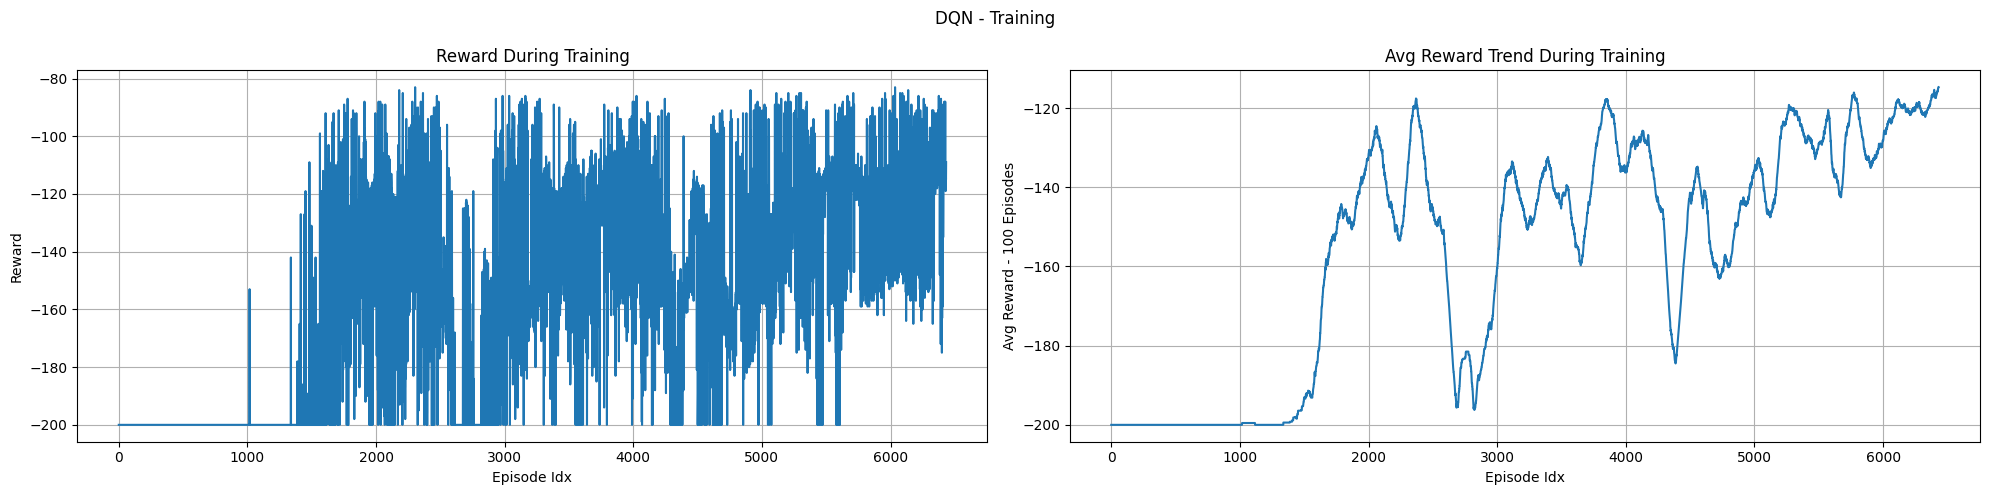

<Figure size 640x480 with 0 Axes>

In [110]:
plotTrainTrend(
    monitor.get_episode_rewards(), 
    len(monitor.get_episode_lengths()),
    "DQN"
)

#### Testing

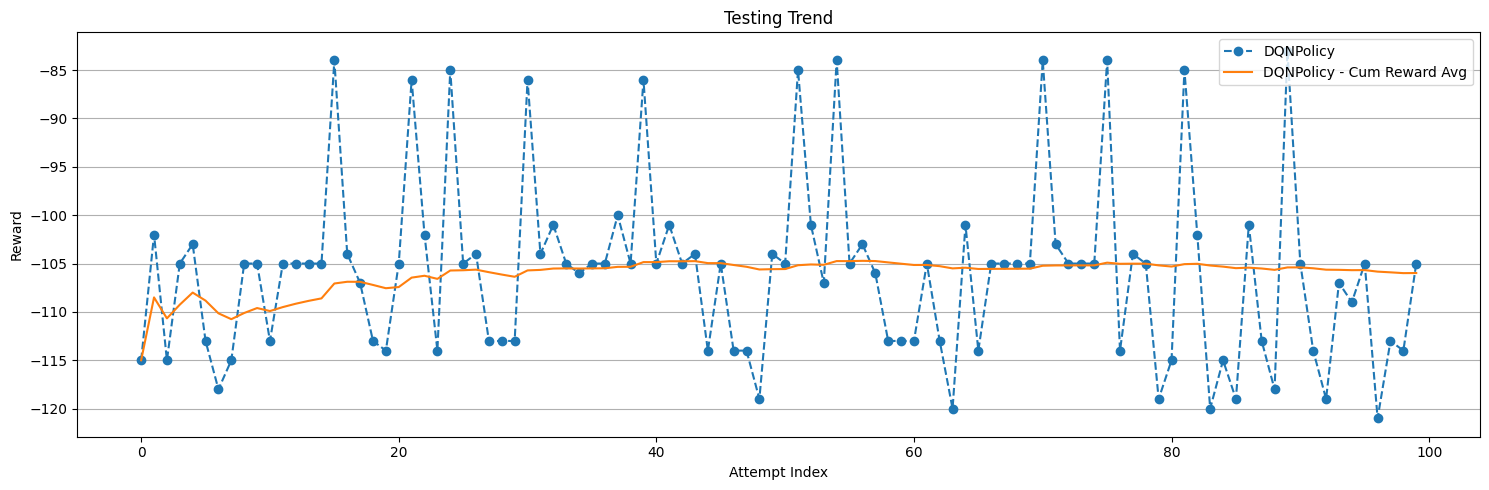

<Figure size 640x480 with 0 Axes>

In [111]:
dqnPolicy = DQNPolicy(dqn)
plotTestTrend([dqnPolicy], TEST_EPISODES, TEST_SEED)

In [112]:
drawTestTable([dqnPolicy], TEST_EPISODES, TEST_SEED)

                                    Testing Reward Info                                     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName ┃ Avg Reward ┃ Reward Std Dev    ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ DQNPolicy   │ -105.98    │ 9.186925492241677 │ -107.81206868892355 / -104.14793131107646 │
└─────────────┴────────────┴───────────────────┴───────────────────────────────────────────┘

# Confronti e Conclusioni
Riportiamo di seguito una tabella riassuntiva dei risultati migliori ottenuti con soluzione tabulare e con soluzione approssimata e un confronto grafico tra le due soluzioni.

Alla luce dei risultati ottenuti, la soluzione con DQN risulta essere la migliore, considerato che ci permette di ottenere un reward medio di $-105.98$, con episodi che raggiungono reward anche prossimi al $-85$. Tuttavia c'è da tenere in conto il tempo di addestramento non indifferente delle DQN e l'ulteriore tempo di tuning (che in questo caso non è stato preso in considerazione): nello specifico si è notato come, all'incirca, il tempo di tuning e addestramento di una soluzione tabulare è più meno uguale al solo tempo di addestramento di una soluzione con *DQN*. Notiamo che lo scarto tra le due soluzioni ottime trovate è di circa $4$ step e inoltre la soluzione con *DoubleQ* risulta essere molto più stabile rispetto a quella con *DQN*: ciò mostra quindi come la soluzione tabulare rimanga comunque una soluzione più che valida nella risoluzione del problema.

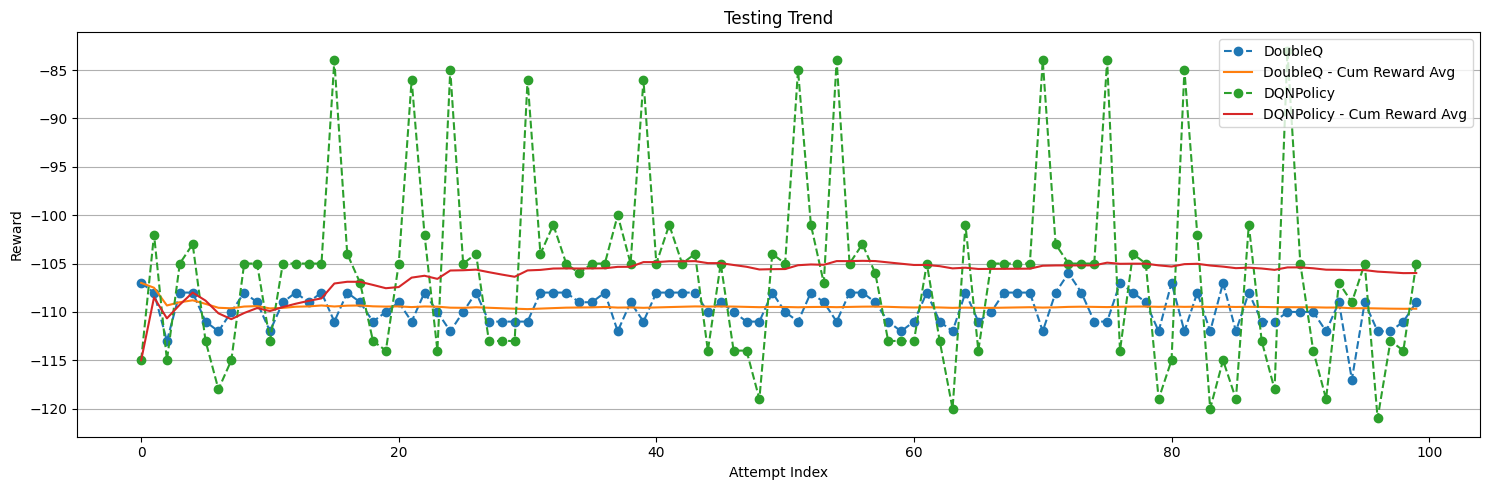

                                     Testing Reward Info                                     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ DoubleQ     │ -109.67    │ 1.7779482557149968 │ -110.02456076492321 / -109.3154392350768  │
│ DQNPolicy   │ -105.98    │ 9.186925492241677  │ -107.81206868892355 / -104.14793131107646 │
└─────────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

<Figure size 640x480 with 0 Axes>

In [113]:
policyList = [doubleQ, dqnPolicy]
plotTestTrend([doubleQ, dqnPolicy], TEST_EPISODES, TEST_SEED)
drawTestTable(policyList, TEST_EPISODES, TEST_SEED)

## Video
Per mostrare il video dell'agente addestrato con DQN, selezionare la politica tramite indice e modificare il valore della variabile *display* a **True**

In [114]:
policyList = [epsilonQ, tauQ, doubleQ, epsilonSarsa, tauSarsa, dqnPolicy]

selectedPolicy = policyList[5]

agent = Agent(selectedPolicy)

display = False
agent.test(10, TEST_SEED, display = display)

array([-115., -102., -115., -105., -103., -113., -118., -115., -105.,
       -105.])